# **Part B: Python Modeling**

- Name: Thaliban Allaam Adristo
- Contact: thalibanallaam@gmail.com

## **Libraries**

Importing necessary libraries to be used in the notebook.

In [194]:
import pandas as pd
from scipy import stats

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

import shap

import warnings
warnings.filterwarnings('ignore')

## **Data Loading**

Loading the dataset.

In [171]:
df = pd.read_csv('../data/credit_scoring.csv')
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.008
5996,506996,40,9944385,4082038,1,477,0,0,0.017
5997,506997,28,9048532,14760384,0,450,0,0,-0.054
5998,506998,51,6843160,11774594,0,561,0,0,0.026


Key Takeaways:
- `leak_col_good` and `leak_col_subtle` needs to be dropped.
- `default` is the target with 0 as paid and 1 as failed payment (based on assumption).

## **Exploratory Data Analysis**

### Initial Data Overview

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [173]:
df.describe().T.applymap('{:,.2f}'.format)

,count,mean,std,min,25%,50%,75%,max
application_id,"6,000.00","503,999.50","1,732.20","501,000.00","502,499.75","503,999.50","505,499.25","506,999.00"
age,"6,000.00",40.32,11.30,21.00,31.00,41.00,50.00,59.00
monthly_income,"6,000.00","11,403,855.81","4,912,598.05","3,000,310.00","7,163,379.00","11,299,453.00","15,737,051.75","19,986,217.00"
loan_amount,"6,000.00","8,001,121.66","4,071,785.59","1,000,794.00","4,440,939.00","7,982,303.50","11,531,445.00","14,998,580.00"
previous_defaults,"6,000.00",0.24,0.48,0.00,0.00,0.00,0.00,3.00
credit_score,"6,000.00",575.98,158.33,300.00,438.75,577.50,713.00,849.00
default,"6,000.00",0.01,0.11,0.00,0.00,0.00,0.00,1.00
leak_col_good,"6,000.00",0.01,0.11,0.00,0.00,0.00,0.00,1.00
leak_col_subtle,"6,000.00",0.01,0.11,-0.12,-0.02,0.00,0.02,1.09


Finding data that are duplicated.

In [174]:
df.duplicated().sum()

0

Target (`default`) distribution.

In [175]:
df['default'].value_counts()

default
0    5927
1      73
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of Default'}, xlabel='default'>

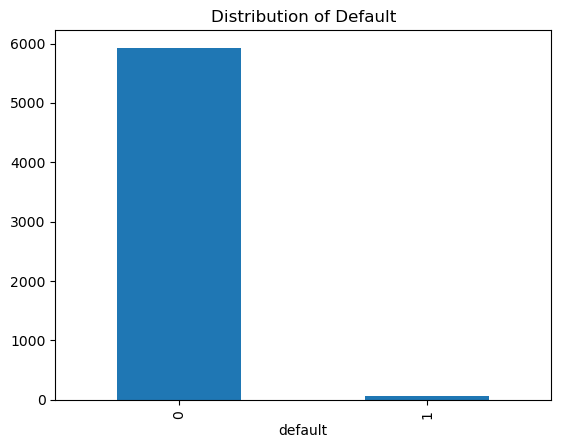

In [176]:
df['default'].value_counts().plot(kind='bar', title='Distribution of Default')

Key Takeaways:
- The data is imbalanced. Therefore, it needs handling during feature engineering.

### Correlation Analysis

Analyzing the correlation between features and the target feature.

In [177]:
def analyze_correlation(df, target_column):
    """
    This function allows you to calculate the relationship between the features in a dataframe and a
    specific target. This function calculates the correlation, Chi-square, Cramer's V, and
    p-value using different methods depending on the data type of the feature.
    Methods in the function:
    - Kendall's method
    - Chi-Squared test
    
    Parameters:
    - df            : Dataframe containing the columns that we want to analyze.
    - target_column : The target column to which the columns from df will be compared to.
        
    Returns:
    pd.DataFrame(results): Results of the calculations made in the function saved in the form of
    a dataframe.
    """
    results = [] #Empty list to store the results of the calculation
    
    for col in df.columns: #When "col" is the same as target, skip to the next value in the loop
        if col == target_column:
            continue

        '''
        Defining a dataframe made from two columns "col" and "target_column" that will be used for the
        calculations. After that, we drop the missing values using "dropna()" because missing values will 
        cause an error during the calculations later on.
        '''
        
        valid_data = df[[col, target_column]].dropna() #Dataframe used for calculations
        
        if len(valid_data) > 1:
            if df[col].dtype in [np.float64, np.int64]: #When "col" is a numerical data, use Kendall's method
                corr, p_value = stats.kendalltau(valid_data[col], valid_data[target_column])
                chi2 = np.nan #Exception handling
                cramer_value = np.nan #Exception handling

            else: #When "col" is a categorical data, use Chi-Squared test
                #Calculate Chi-Square value
                contingency_table = pd.crosstab(valid_data[col], valid_data[target_column])
                chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
                corr = np.nan #Exception handling

                #Parameters for Cramer's V
                N = contingency_table.sum().sum()
                r, k = contingency_table.shape
                rcorr = r - 1  # Rows - 1
                kcorr = k - 1  # Columns - 1

                #Chi2 bias correction
                chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (N - 1))

                #Calculate Cramer's V value
                cramer_value =  np.sqrt((chi2corr/N) / min(kcorr, rcorr))  # Cramér's V
        else:
            corr, p_value = np.nan, np.nan  #Exception handling
            cramer_value = np.nan #Exception handling
        results.append({
            "Feature": col,
            "Correlation Value": corr,
            "Cramer's Value": cramer_value,
        })
    
    return pd.DataFrame(results)

In [178]:
# Analyze features from "df" dataframe with 'Obesity Level' as the target
df_corr = analyze_correlation(df, 'default')

df_corr

,Feature,Correlation Value,Cramer's Value
0,application_id,0.022996,NaN
1,age,0.009670,NaN
2,monthly_income,-0.046706,NaN
3,loan_amount,0.059291,NaN
4,previous_defaults,0.044383,NaN
5,credit_score,-0.051967,NaN
6,leak_col_good,1.000000,NaN
7,leak_col_subtle,0.155760,NaN


## **Feature Engineering**

Dropping unnecessary features.

In [179]:
df.drop(columns=['leak_col_good', 'leak_col_subtle'], inplace=True)
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0
5996,506996,40,9944385,4082038,1,477,0
5997,506997,28,9048532,14760384,0,450,0
5998,506998,51,6843160,11774594,0,561,0


## **Modeling**

### Logistic Regression

In [180]:
# Features and target
X = df.drop(columns=["application_id", "default"])
y = df["default"]

In [181]:
# Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)

Train size :  (4800, 5)
Test size  :  (1200, 5)


In [182]:
# Feature Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-0.20279813, -1.3056889 , -0.01138959, -0.49790346,  0.40070913],
       [ 1.30392381, -0.65596335,  1.60732003, -0.49790346, -0.85411451],
       [-0.55732094,  1.36630428, -1.00690788,  3.61558465, -0.54991484],
       ...,
       [-0.82321304, -0.26998974,  1.38664681, -0.49790346,  0.83165866],
       [-0.11416742, -1.41882951, -1.0357839 , -0.49790346, -1.54490126],
       [ 0.50624749,  1.18163978,  1.63013077, -0.49790346,  1.18022078]])

In [183]:
# Logistic Regression with balanced class weight
logreg = LogisticRegression(class_weight="balanced", random_state=10)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', random_state=10)

In [184]:
# Predict and evaluate
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82      1185
           1       0.04      0.87      0.07        15

    accuracy                           0.70      1200
   macro avg       0.52      0.78      0.45      1200
weighted avg       0.99      0.70      0.81      1200

ROC AUC Score: 0.820309423347398


### GradientBoosting


In [185]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [186]:
xgb = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=10
)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=10, ...)

In [187]:
# Predictions
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

xgb_report = classification_report(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)


print(xgb_report)
print("ROC AUC Score:", xgb_auc)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200

ROC AUC Score: 0.7552742616033755


Conclusion:
- Based on ROC AUC score, Logistic Regression model outperforms GradientBoosting.
- Possible causes:
    - Extreme data imbalance
    - Dataset size

## **Scorecard Scaling**

Scale used: 300 - 850
- Lower score means higher probability (of payment failure)
- Higher score means lower probability 

In [188]:
# Function to convert probability to score
def probability_to_score(prob):
    return (1 - prob) * (850 - 300) + 300

In [189]:
# Calculate scores from Logistic Regression probabilities
score = probability_to_score(y_prob)

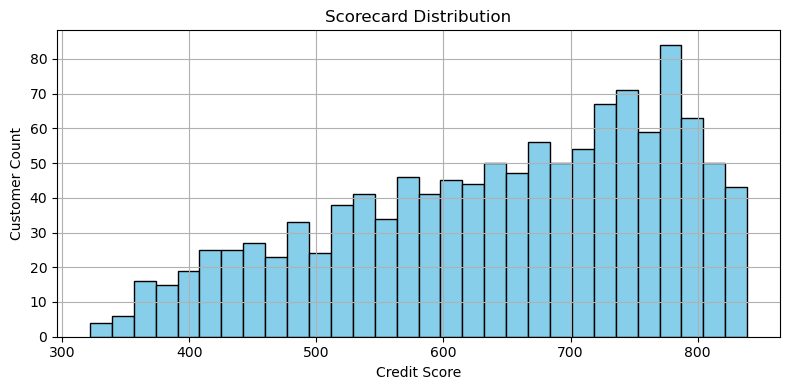

In [190]:
# Plot
plt.figure(figsize=(8, 4))
plt.hist(score, bins=30, color="skyblue", edgecolor="black")
plt.title("Scorecard Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Customer Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Key Takeaways:
- The scorecard distribution is skewed to the right which means that the majority of customers have a high credit score.

## **SHAP**

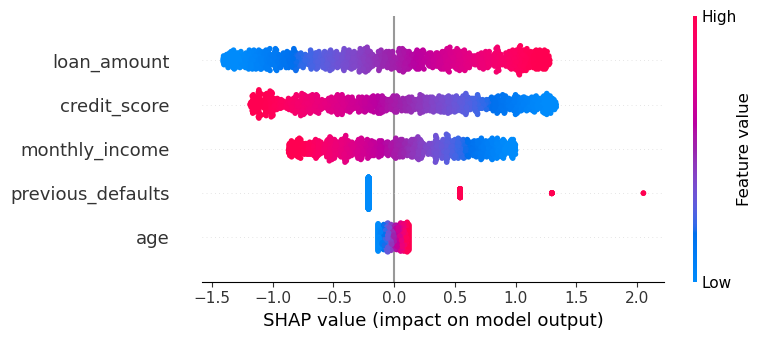

In [196]:
# Define the explainer
explainer = shap.LinearExplainer(logreg, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Plot
plt.figure()
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, max_display=10)


Key Takeaways:
- The top 3 most influential features are `loan_amount`, `credit_score`, and `monthly_income`.
- Positive SHAP value indicates positive class (payment failure).
- Payment failure tend to happen with high loan amount, low credit score, and low monthly income.
- `age` has a very limited impact on the prediction process.